# Mutual Information Estimation

$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

In [2]:
# init
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorboard as tb
import torch
import torch.optim as optim
from IPython import display
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
%matplotlib inline


def plot_samples_with_kde(df, **kwargs):
    p = sns.PairGrid(df, **kwargs)
    p.map_lower(sns.scatterplot, s=2)  # scatter plot of samples
    p.map_upper(sns.kdeplot)  # kernel density estimate for pXY
    p.map_diag(sns.kdeplot)  # kde for pX and pY
    return p


SEED = 0

# set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# create samples
XY_rng = np.random.default_rng(SEED)
rho = 1 - 0.19 * XY_rng.random()
mean, cov, n = [0, 0], [[1, rho], [rho, 1]], 1000
XY = XY_rng.multivariate_normal(mean, cov, n)

XY_ref_rng = np.random.default_rng(SEED)
cov_ref, n_ = [[1, 0], [0, 1]], n
XY_ref = XY_ref_rng.multivariate_normal(mean, cov_ref, n_)

Z = Tensor(XY).to(DEVICE)
Z_ref = Tensor(XY_ref).to(DEVICE)

ground_truth = -0.5 * np.log(1 - rho ** 2)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**How to estimate MI via KL divergence?**

In this notebook, we will introduce a few methods of estimating the mutual information ({prf:ref}`mi-estimation`) via KL divergence.

We first introduce the Mutual Information Neural Estimation (MINE) method in {cite}`belghazi2018mine`.

## MINE

The idea is to obtain MI {eq}`MI` from KL divergence {eq}`D` as follows:

$$
\begin{align*}
I(\R{X}\wedge \R{Y}) = D(\underbrace{P_{\R{X},\R{Y}}}_{P_{\R{Z}}}\| \underbrace{P_{\R{X}}\times P_{\R{Y}}}_{P_{\R{Z}'}}).
\end{align*}
$$

and then apply the DV formula {eq}`avg-DV` to estimate the divergence:

---

**Definition** MINE  
:label: MINE

The idea of mutual information neural estimation (MINE) is to estimate $I(\R{X}\wedge\R{Y})$ by

$$
\begin{align}
\sup_{t_{\theta}: \mc{Z} \to \mathbb{R}} \overbrace{\frac1n \sum_{i\in [n]} t_{\theta}(\R{X}_i,\R{Y}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\theta}(\R{X}'_i,\R{Y}'_i)}}^{\R{I}_{\text{MINE}}(\theta):=}
\end{align}
$$ (MINE)

where 

- the supremum is over $t_{\theta}$ representable by a neural network with trainable/optimizable parameters $\theta$,
- $P_{\R{X}',\R{Y}'}:=P_{\R{X}}\times P_{\R{Y}}$, and
- $(\R{X}'_i,\R{Y}'_i\mid i\in [n'])$ is the sequence of i.i.d. samples of $P_{\R{X}',\R{Y}'}$.

---

The above is not a complete description of MINE because there are some implementation details yet to be filled in.

### Resampling

**How to obtain the reference samples ${\R{Z}'}^{n'}$, i.e., ${\R{X}'}^{n'}$ and ${\R{Y}'}^{n'}$?**

We can approximate the i.i.d. sampling of $P_{\R{X}}\times P_{\R{Y}}$ using samples from $P_{\R{X},\R{Y}}$ by a re-sampling trick:

$$
\begin{align}
P_{\R{Z}'^{n'}} &\approx P_{((\R{X}_{\R{J}_i},\R{Y}_{\R{K}_i})\mid i \in [n'])}
\end{align}
$$ (resample)

where $\R{J}_i$ and $\R{K}_i$ for $i\in [n']$ are independent and uniformly random indices

$$
P_{\R{J},\R{K}} = \op{Uniform}_{[n]\times [n]}
$$

and $[n]:=\Set{1,\dots,n}$.

MINE {cite}`belghazi2018mine` uses the following implementation that samples $(\R{J},\R{K})$ but without replacement. You can change $n'$ using the slider for `n_`.

In [3]:
rng = np.random.default_rng(SEED)


def resample(data, size, replace=False):
    index = rng.choice(range(data.shape[0]), size=size, replace=replace)
    return data[index]


@widgets.interact(n_=widgets.IntSlider(n, 2, n, continuous_update=False))
def plot_resampled_data_without_replacement(n_):
    XY_ = np.block([resample(XY[:, [0]], n_), resample(XY[:, [1]], n_)])
    resampled_data = pd.DataFrame(XY_, columns=["X'", "Y'"])
    plot_samples_with_kde(resampled_data)
    plt.show()

interactive(children=(IntSlider(value=1000, continuous_update=False, description='n_', max=1000, min=2), Outpu…

In the above, the function `resample`
- uses `choice` to uniformly randomly select a choice
- from a `range` of integers going from `0` to 
- the size of the first dimension of the `data`.

Note however that the sampling is without replacement.

**Is it a good idea to sample without replacement?**

**Exercise**

Sampling without replacement has an important restriction $n'\leq n$. Why?

**Solution**

To allow $n>n'$, at least one sample $(\R{X}_i,\R{Y}_i)$ needs to be sampled more than once.

**Exercise** To allow $n>n'$, complete the following code to sample with replacement and observe what happens when $n \gg n'$.

In [4]:
@widgets.interact(n_=widgets.IntSlider(n, 2, 10 * n, continuous_update=False))
def plot_resampled_data_with_replacement(n_):
    ### BEGIN SOLUTION
    XY_ = np.block(
        [resample(XY[:, [0]], n_, replace=True), resample(XY[:, [1]], n_, replace=True)]
    )
    ### END SOLUTION
    resampled_data = pd.DataFrame(XY_, columns=["X'", "Y'"])
    plot_samples_with_kde(resampled_data)
    plt.show()

interactive(children=(IntSlider(value=1000, continuous_update=False, description='n_', max=10000, min=2), Outp…

**Exercise** 

Explain whether the resampling trick gives i.i.d. samples $(\R{X}_{\R{J}_i},\R{Y}_{\R{K}_i})$ for the cases with replacement and without replacement respectively?

**Solution** 

The samples are identically distributed. However, they are not independent except in the trivial case $n=1$ or $n'=1$, regardless of whether the sample is with replacement or not. Consider $n=1$ and $n'=2$ as an example.

### Smoothing

To improve the stability of the training, MINE applies additional smoothing to the gradient calculation.

**How to train the neural network?**

{eq}`MINE` can be solved iteratively by minibatch gradient descent using the loss function:

$$
\begin{align}
\R{L}_{\text{MINE}}(\theta) &:= \overbrace{- \frac{1}{\abs{\R{B}}} \sum_{i\in \R{B}}  t_{\theta} (\R{X}_i, \R{Y}_i) }^{\R{L}(\theta):=} + \log \overbrace{\frac{1}{\abs{\R{B}'}} \sum_{i\in \R{B}'}  e^{t_{\theta} (\R{X}'_i, \R{Y}'_i)}}^{\R{L}'(\theta):=}
\end{align}
$$

where $\R{B}$ and $\R{B}'$ are batches of uniformly randomly chosen indices from $[n]$ and $[n']$ respectively.

The gradient expressed in terms of $\R{L}$ and $\R{L}'$ is:

$$
\begin{align}
\nabla \R{L}_{\text{MINE}}(\theta) &= \nabla \R{L}(\theta) + \frac{\nabla \R{L}'(\theta)}{\R{L}'(\theta)}.
\end{align}
$$

Variation in $\nabla \R{L}'(\theta)$ leads to the variation of the overall gradient especially when $\R{L}'(\theta)$ is small. With minibatch gradient descent, the sample average is over a small batch and so the variance can be quite large.

**How to reduce the variation in the gradient approximation?**

To alleviate the variation, MINE replaces the denominator $\R{L}'(\theta)$ by its moving average:

$$
\theta_{j+1} := \theta_j - s_j \underbrace{\left(\nabla \R{L}_j (\theta_j) + \frac{\nabla \R{L}'_j(\theta_j)}{\overline{\R{L}'}_j}\right)}_{\text{(*)}}
$$ (MINE:update)

where $\R{L}_j$ and $\R{L}'_j$ are the 

$$
\overline{\R{L}'}_j =  \beta \overline{\R{L}'}_{j-1} + (1-\beta) \R{L}'(\theta_j)
$$ (MINE:L2bar)

for some smoothing factor $\beta\in [0,1]$.

**How to implement the smoothing?**

Instead of implementing a new optimizer, a simpler way is to redefine the loss at each step $i$ as follows {cite}`belghazi2018mine`:

$$
\R{L}_{\text{MINE},j}(\theta) = \R{L}_j(\theta) + \frac{\R{L}'_j(\theta)}{\overline{\R{L}'}_j}
$$ (MINE:mv)

where $\overline{\R{L}'}_j$ in {eq}`MINE:L2bar` is regarded as a constant in calculating the gradient. It is easy to verify that $\nabla \R{L}_{\text{MINE},j}(\theta_j)$ gives the desired gradient (*) in {eq}`MINE:update`.

In summary:

---

**Definition**

MINE estimates the mutual information $I(\R{X}\wedge\R{Y})$ as $\R{I}_{\text{MINE}}(\theta_j)$ {eq}`MINE` where $\theta_j$ is updated by descending along the gradient of $\R{L}_{\text{MINE},j}$ {eq}`MINE:mv` iteratively after $j$ steps.

---

### Implementation

Consider implementing MINE for the jointly gaussian $\R{X}$ and $\R{Y}$:

In [5]:
SEED = 0

# set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# create samples
XY_rng = np.random.default_rng(SEED)
rho = 1 - 0.19 * XY_rng.random()
mean, cov, n = [0, 0], [[1, rho], [rho, 1]], 1000
XY = XY_rng.multivariate_normal(mean, cov, n)

X = Tensor(XY[:, [0]]).to(DEVICE)
Y = Tensor(XY[:, [1]]).to(DEVICE)
ground_truth = -0.5 * np.log(1 - rho ** 2)
X.shape, Y.shape, ground_truth

(torch.Size([1000, 1]), torch.Size([1000, 1]), 0.7405246745135301)

The tensors `X` and `Y` correspond to samples of $\R{X}$ and $\R{Y}$ respectively. The first dimension indices the different samples. The `ground_truth` is the actual mutual information $I(\R{X}\wedge\R{Y})$.

**Exercise**

Complete the definition of `forward` so that the neural network $t_{\theta}$ is a vectorized function that takes samples `x` and `y` of $\R{X}$ and $\R{Y}$ as input and approximates the density ratio $\frac{P_{\R{X},\R{Y}}}{P_{\R{X}}\times P_{\R{Y}}}$ at `(x, y)`:

![Neural network](images/nn.dio.svg)

- Use `torch.cat` to concatenate tensors `x` and `y` in the last dimension.
- Use `F.elu` for the activation function $\sigma$.

In [31]:
class Net(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        # fully-connected (fc) layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # layer 2
        self.fc3 = nn.Linear(hidden_size, 1)  # layer 3
        nn.init.normal_(self.fc1.weight, std=sigma)  #
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, x, y):
        """
        Vectorized function that implements the neural network t(x,y).

        Parameters:
        -----------
        x, y: 2D Tensors where the first dimensions index different samples.
        """
        ### BEGIN SOLUTION
        a1 = F.elu(self.fc1(torch.cat([x, y], dim=-1)))
        a2 = F.elu(self.fc2(a1))
        t = self.fc3(a2)
        ### END SOLUTION
        return t

    def plot(self, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None):
        """Plot a heat map of a neural network net. net can only have two inputs."""
        x, y = np.mgrid[xmin : xmax : xgrids * 1j, ymin : ymax : ygrids * 1j]
        with torch.no_grad():
            z = (
                net(
                    Tensor(x.reshape(-1, 1)).to(DEVICE),
                    Tensor(y.reshape(-1, 1)).to(DEVICE),
                )
                .reshape(x.shape)
                .cpu()
            )
        if ax is None:
            ax = plt.gca()
        im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
        ax.figure.colorbar(im)
        ax.set(xlabel=r"$x$", ylabel=r"$y$", title=r"Heatmap of $t(x,y)$")

To create and plot the neural network:

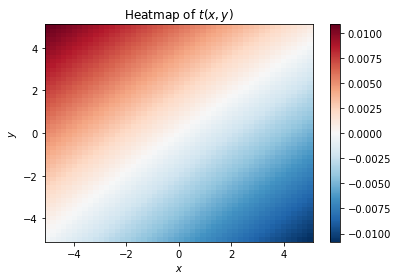

In [41]:
torch.manual_seed(SEED)
net = Net().to(DEVICE)
net.plot()

**Exercise**

To implement a neural network trainer for MINE similar to `DVTrainer`, completes the definition of `loss` according to {eq}`MINE:mv`:

In [42]:
class MINETrainer:
    def __init__(
        self, X, Y, net, n_iters_per_epoch, writer_params={}, m=1, beta=0.1, **kwargs
    ):
        """
        Neural estimator for Mutual Information based on MINE.

        Estimate I(X;Y) using samples of X and Y by training a network t to maximize
            avg(t(X,Y)) - avg(e^t(X',Y')) / m
        where samples of (X',Y') approximates P_X * P_Y using the resampling trick, and
        m is obtained by smoothing avg(e^t(X',Y')) with the factor beta.

        parameters:
        -----------

        X, Y : Tensors with first dimensions of the same size indicing the samples.
        net  : The neural network t that takes X and Y as input and output a real number for each a real number for each sample.
        n_iters_per_epoch : Number of iterations per epoch.
        m    : initial value for the moving average
        beta : Smoothing/forgetting factor between [0,1]
        writer_params     : Parameters to be passed to SummaryWriter for logging.
        """
        self.X = X
        self.Y = Y
        self.n = min(X.shape[0], Y.shape[0])
        self.beta = beta
        self.m = m
        self.net = net
        self.n_iters_per_epoch = n_iters_per_epoch

        # set optimizer
        self.optimizer = optim.Adam(self.net.parameters(), **kwargs)

        # logging
        self.writer = SummaryWriter(**writer_params)
        self.n_iter = self.n_epoch = 0

    def step(self, epochs=1):
        """
        Carries out the gradient descend for a number of epochs and returns the MI estimate evaluated over the entire data.

        Loss for each epoch is recorded into the log, but only one MI estimate is computed/logged using the entire dataset.
        Rerun the method to continue to train the neural network and log the results.

        Parameters:
        -----------
        epochs : number of epochs
        """
        for i in range(epochs):
            self.n_epoch += 1

            # random indices for selecting samples for all batches in one epoch
            idx = torch.randperm(self.n)

            # resampling to approximate the sampling of (X',Y')
            idx_X = torch.randperm(self.n)
            idx_Y = torch.randperm(self.n)

            for j in range(self.n_iters_per_epoch):  # loop through multiple batches
                self.n_iter += 1
                self.optimizer.zero_grad()

                # obtain a random batch of samples
                batch_X = self.X[idx[j : self.n : self.n_iters_per_epoch]]
                batch_Y = self.Y[idx[j : self.n : self.n_iters_per_epoch]]
                batch_X_ref = self.X[idx_X[j : self.n : self.n_iters_per_epoch]]
                batch_Y_ref = self.Y[idx_Y[j : self.n : self.n_iters_per_epoch]]

                # define the loss
                # BEGIN SOLUTION
                L = -self.net(batch_X, batch_Y).mean()
                L_ = self.net(batch_X_ref, batch_Y_ref).exp().mean()
                self.m = (1 - self.beta) * L_.detach() + self.beta * self.m
                loss = L + L_ / self.m
                # END SOLUTION
                loss.backward()
                self.optimizer.step()

            self.writer.add_scalar("Loss/train", loss.item(), global_step=self.n_iter)

        with torch.no_grad():
            idx_X = torch.randperm(self.n)
            idx_Y = torch.randperm(self.n)
            X_ref = self.X[idx_X]
            Y_ref = self.Y[idx_Y]
            estimate = (
                self.net(self.X, self.Y).mean()
                - self.net(X_ref, Y_ref).logsumexp(0)
                + np.log(self.n)
            ).item()
            self.writer.add_scalar("Estimate", estimate, global_step=self.n_epoch)
            return estimate

To create the trainer for MINE:

In [43]:
trainer = MINETrainer(X, Y, net, n_iters_per_epoch=10)

To train the neural network:

Train? [Y/n] 


MI estimate: 0.6630358695983887
MI estimate: 0.7220616340637207
MI estimate: 0.6985311508178711
MI estimate: 0.7042741775512695
MI estimate: 0.6722865104675293


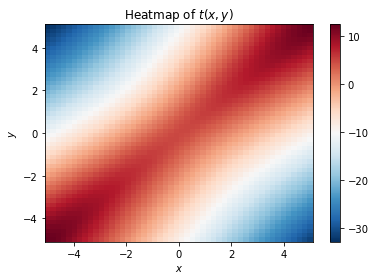

In [48]:
if input("Train? [Y/n]").lower() != "n":
    for i in range(10):
        print('MI estimate:', trainer.step(10))
    net.plot()

In [49]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 5413), started 0:01:34 ago. (Use '!kill 5413' to kill it.)

**Exercise** 

See if you can get an estimate close to the ground truth by training the neural network repeated as shown below.

![MI estimate](images/MI_est.dio.svg)

To clean-up:

In [40]:
if input('Delete logs? [y/N]').lower() == 'y':
    !rm -rf ./runs

Delete logs? [y/N] y


In [46]:
tb.notebook.list() # list all the running TensorBoard notebooks.
while (pid := input('pid to kill? (press enter to exit)')):
    !kill {pid}

Known TensorBoard instances:
  - port 6007: logdir runs (started 0:18:01 ago; pid 5113)
  - port 6006: logdir runs (started 1:17:51 ago; pid 4485)


pid to kill? (press enter to exit) 5113
pid to kill? (press enter to exit) 4485
pid to kill? (press enter to exit) 


## MI-NEE

**Is it possible to generate i.i.d. samples for ${\R{Z}'}^{n'}$?**

Consider another formula for mutual information:

---

**Proposition**  
:label: MI-3D

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'}) - D(P_{\R{X}}\|P_{\R{X}'}) - D(P_{\R{Y}}\|P_{\R{Y}'})
\end{align}
$$ (MI-3D)

for any product reference distribution $P_{\R{X}'}\times P_{\R{Y}'}$ for which the divergences are finite.

---

---

**Corollary**  
:label: MI-ub


$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= \inf_{\substack{P_{\R{X}'}\in \mc{P}(\mc{X})\\ P_{\R{Y}'}\in \mc{P}(\mc{Y})}} D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'}).
\end{align}
$$ (MI-ub)

where the optimal solution is $P_{\R{X}'}\times P_{\R{Y}'}=P_{\R{X}}\times P_{\R{Y}}$, the product of marginal distributions of $\R{X}$ and $\R{Y}$. 

---

---

**Proof**

{eq}`MI-ub` follows from {eq}`MI-3D` directly since the divergences are non-negative. To prove the proposition:

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &= H(\R{X}) + H(\R{Y}) - H(\R{X},\R{Y})\\
&= E\left[-\log dP_{\R{X}'}(\R{X})\right] - D(P_{\R{X}}\|P_{\R{X}'})\\
&\quad+E\left[-\log dP_{\R{Y}'}(\R{Y})\right] - D(P_{\R{Y}}\|P_{\R{Y}'})\\
&\quad-E\left[-\log d(P_{\R{X}'}\times P_{\R{Y}'})(\R{X},\R{Y})\right] + D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'})\\
&= D(P_{\R{X},\R{Y}}\|P_{\R{X}'}\times P_{\R{Y}'}) - D(P_{\R{X}}\|P_{\R{X}'}) - D(P_{\R{Y}}\|P_{\R{Y}'})
\end{align}
$$

---

*Mutual Information Neural Entropic Estimation (MI-NEE)* {cite}`chan2019neural` uses {eq}`MI-3D` to estimate MI by estimating the three divergences.

Applying {eq}`avg-DV` to each divergence in {eq}`MI-3D`:

$$
\begin{align}
I(\R{X}\wedge \R{Y}) &\approx \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t_{\R{X},\R{Y}}(\R{X}_i,\R{Y}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\R{X},\R{Y}}(\R{X}'_i,\R{Y}'_i)}\\
&\quad - \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t_{\R{X}}(\R{X}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\R{X}}(\R{X}'_i)} \\
&\quad - \sup_{t: \mc{Z} \to \mathbb{R}} \frac1n \sum_{i\in [n]} t_{\R{Y}}(\R{Y}_i) - \frac1{n'}\sum_{i\in [n']} e^{t_{\R{Y}}(\R{Y}'_i)}
\end{align}
$$ (MI-NEE)

$P_{\R{X}'}$ and $P_{\R{Y}'}$ are known distributions and so arbitrarily many i.i.d. samples can be drawn from them directly without using the resampling trick {eq}`resample`.

Indeed, since the choice of $P_{\R{X}'}$ and $P_{\R{Y}'}$ are arbitrary, we can also also train neural networks to optimize them. In particular, {eq}`MI-ub` is a special case where we can train neural networks to approximate $P_{\R{X}}$ and $P_{\R{Y}}$.